# <center>Finding QAOA optimal angles </center>

Imports:

In [9]:
import os, sys
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
path = os.path.abspath('..')
sys.path.append(path)

Our code offers a QAOA class to wrap around all standard operations one might to do with QAOA:

In [8]:
from qubitrbm.qaoa import QAOA

We generate a networkx graph for our example and optimize to find angles at $p=1$

In [59]:
G = nx.random_regular_graph(3, 16, seed=123)

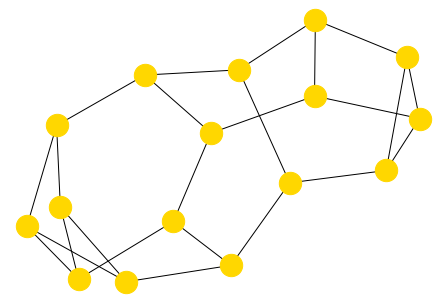

In [60]:
nx.draw_kamada_kawai(G, node_color='gold', node_size=500)

In [81]:
qaoa = QAOA(G)

The QAOA class wraps around the cirq simulator and offers an array of potentially useful methods:

In [77]:
# MaxCut cost calculation from samples
B = np.random.rand(100, 20) > 0.5
qaoa.cost(B).shape

(100,)

In [63]:
# The Cirq circuit object (dynamically updated when p or the graph changes)
type(qaoa.circuit)

cirq.circuits.circuit.Circuit

In [64]:
# The underlying graph
type(qaoa.graph)

networkx.classes.graph.Graph

In [65]:
# Circuit simulation and sampling (Cirq)

gamma, beta = np.random.rand(2)

psi = qaoa.simulate(gamma, beta).final_state
samples = qaoa.sample(gamma, beta, n_samples=100)

print(psi.shape)
print(samples.shape)

(65536,)
(100, 16)


In [66]:
# Different ways of calculating the MaxCut cost and its gradients

gamma, beta = np.random.rand(2)

exact_cost = qaoa.exact_cost(gamma, beta) # Only works at p=1
cost = qaoa.cost_from_probs(np.abs(psi)**2)

exact_grad = qaoa.exact_grad_cost(gamma, beta) # Only works at p=1
num_grad = qaoa.num_grad_cost(gamma, beta, dx=1e-5) # Uses circuit simulation in the background

print(cost, exact_cost)
print(num_grad, exact_grad)

1.992008923595023 1.617914434775749
[16.54727609  8.84090562] [16.5472761   8.84090562]


## $p=1$ optimization:

Plot the cost landscape:

In [67]:
gammas = np.linspace(0, np.pi/2, 300)
betas = np.linspace(-np.pi/4, np.pi/4, 300)

In [68]:
g, b = np.meshgrid(gammas, betas)

At $p=1$, the exact cost formula is available:

In [69]:
%time costs_grid = qaoa.exact_cost(g, b)

CPU times: user 99.8 ms, sys: 5.74 ms, total: 106 ms
Wall time: 107 ms


Find the optimal angles, starting intentionally from a bad point. The optimizer used to find optimal angles is Adam but the way we calculate cost derivatives differs between different $p$.

For $p=1$, we have access to an exact expression which is automatically used by the QAOA class. If $p>1$, numerical finite-difference approximations are used, increasing the runtime significantly.

In [70]:
%time angles, costs = qaoa.optimize(init=[np.pi/8, np.pi/8], tol=1e-5)

CPU times: user 196 ms, sys: 3.98 ms, total: 200 ms
Wall time: 200 ms


In [71]:
gamma_opt, beta_opt = angles

Text(0, 0.5, '$\\langle \\mathcal{C} \\rangle $')

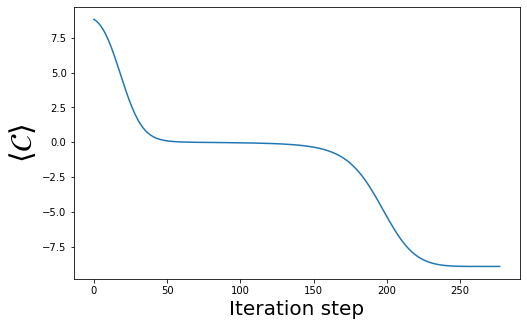

In [72]:
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(costs)
ax.set_xlabel('Iteration step', fontsize=20)
ax.set_ylabel(r'$\langle \mathcal{C} \rangle $', fontsize=30)

Plot the final result:

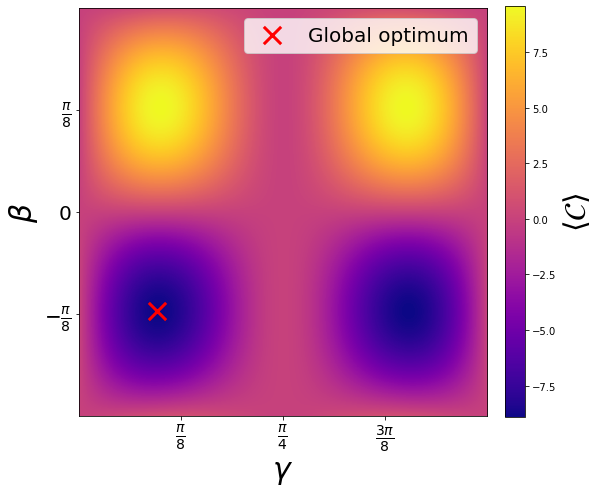

In [73]:
fig, ax = plt.subplots(figsize=[8,8])

m = ax.imshow(costs_grid[::-1,:], cmap='plasma', extent=(0, np.pi/2, -np.pi/4, np.pi/4))
ax.scatter([gamma_opt], [beta_opt], marker='x', c='red', s=300, lw=3, label='Global optimum', zorder=10)

ax.set_xticks([np.pi/8, np.pi/4, 3*np.pi/8])
ax.set_xticklabels([r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$'], fontsize=20)
ax.set_yticks([-np.pi/8, 0, np.pi/8])
ax.set_yticklabels([r'$-\frac{\pi}{8}$', r'$0$', r'$\frac{\pi}{8}$'], fontsize=20)

ax.set_xlabel(r'$\gamma $', fontsize=30)
ax.set_ylabel(r'$\beta $', rotation=90, fontsize=30)

ax.legend(frameon=True, fontsize=20)

cb = fig.colorbar(m, ax=ax, fraction=0.046, pad=0.04)
cb.set_label(r'$\langle \mathcal{C} \rangle $', fontsize=30)

# $p=2$

Setting p=2 directly will automatically update the circuit and default the optimizer to numerical gradients:

In [83]:
qaoa.p = 2

In [89]:
%time angles2, costs2 = qaoa.optimize(init=[np.pi/8, np.pi/8, 0, 0], tol=1e-3)

Iteration  10 | Cost = -1.9159
Iteration  20 | Cost = -6.0156
Iteration  30 | Cost = -9.5911
Iteration  40 | Cost = -9.7919
CPU times: user 50 s, sys: 1.37 s, total: 51.4 s
Wall time: 51.5 s


Text(0, 0.5, '$\\langle \\mathcal{C} \\rangle $')

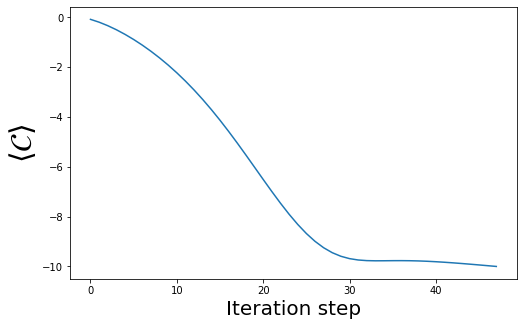

In [91]:
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(costs2)
ax.set_xlabel('Iteration step', fontsize=20)
ax.set_ylabel(r'$\langle \mathcal{C} \rangle $', fontsize=30)

In [92]:
gammas2, betas2 = np.split(angles2, 2)

In [93]:
gammas2

array([0.18945646, 0.20487192])

In [94]:
betas2

array([-0.24676129, -0.28418563])